In [3]:
from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper, ArxivAPIWrapper

In [6]:
arxiv_api_wrapper = ArxivAPIWrapper(top_k_results=2, doc_content_chars_max=500)
arxiv = ArxivQueryRun(api_wrapper=arxiv_api_wrapper)

In [7]:
arxiv.invoke("what is attention all you need?")

'Published: 2018-06-28\nTitle: Quit When You Can: Efficient Evaluation of Ensembles with Ordering Optimization\nAuthors: Serena Wang, Maya Gupta, Seungil You\nSummary: Given a classifier ensemble and a set of examples to be classified, many examples may be confidently and accurately classified after only a subset of the base models in the ensemble are evaluated. This can reduce both mean latency and CPU while maintaining the high accuracy of the original ensemble. To achieve such gains, we propose j'

In [12]:
wiki_api_wrapper = WikipediaAPIWrapper(top_k_results=1, doc_content_chars_max=1000)
wikipedia = WikipediaQueryRun(api_wrapper=wiki_api_wrapper)

In [13]:
wikipedia.invoke("Who is Salman Khan?")

"Page: Salman Khan\nSummary: Salman Salim Khan (born Abdul Rashid Salim Salman Khan, 27 December 1965) is an Indian actor, film producer, and television personality who predominantly works in Hindi films. In a career spanning over three decades, his awards include two National Film Awards as a film producer, and two Filmfare Awards as an actor. He has been cited in the media as one of the most popular and commercially successful actors of Indian cinema. Forbes included him in listings of the highest-paid celebrities in the world, in 2015 and 2018.\nKhan began his acting career with a supporting role in Biwi Ho To Aisi (1988), followed by his breakthrough with a leading role in Sooraj Barjatya's romantic drama Maine Pyar Kiya (1989), for which he was awarded the Filmfare Award for Best Male Debut. He established himself with other commercially successful films, including Lawrence D'Souza's romantic drama Saajan (1991), Barjatya's family dramas Hum Aapke Hain Koun..! (1994) and Hum Saath

In [16]:
import os
from dotenv import load_dotenv

load_dotenv()

os.environ["TAVILY_API_KEY"] = os.getenv('TAVILY_API_KEY')
os.environ['GROQ_API_KEY'] = os.getenv('GROQ_API_KEY')

In [19]:
from langchain_tavily import TavilySearch

tavily = TavilySearch(
    max_results=5,
    topic="general"
)

In [20]:
tavily.invoke("Current news on Iran")

{'query': 'Current news on Iran',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://www.cnn.com/world/middleeast/iran',
   'title': 'Iran news - breaking stories, video and analysis | CNN',
   'content': "LATEST NEWS\u200b\u200b Trump claimed Iran is building missiles that could soon hit the US. Sources say that's not backed up by US intelligence.",
   'score': 0.99664956,
   'raw_content': None},
  {'url': 'https://www.reuters.com/world/iran/',
   'title': 'Iran News | Latest Headlines & Stories - Reuters',
   'content': 'Israel launched a "pre-emptive" attack against Iran on Saturday, and a major United States attack is underway, plunging the Middle East into a renewed',
   'score': 0.99528164,
   'raw_content': None},
  {'url': 'https://www.youtube.com/watch?v=PU1DBIqm0Uc',
   'title': 'LIVE: President Trump confirms "major combat operations" in Iran',
   'content': 'Watch 24/7 coverage of breaking news and live events on ABC News Live: ... 

In [21]:
tools = [arxiv, tavily, wikipedia]

In [27]:
##Initialize LLM model
from langchain_groq import ChatGroq

llm = ChatGroq(model="qwen/qwen3-32b")
llm_with_tools = llm.bind_tools(tools)

In [29]:
from langchain_core.messages import HumanMessage, AIMessage
from pprint import pprint

llm_with_tools.invoke([HumanMessage(content="What is the latest trending news")])

AIMessage(content='', additional_kwargs={'reasoning_content': 'Okay, the user is asking for the latest trending news. I need to figure out which tool to use here. Let me check the available functions.\n\nFirst, there\'s the arxiv function, but that\'s for academic papers in specific fields like physics and computer science. The user isn\'t asking about research, so probably not that.\n\nNext, the wikipedia function. Wikipedia is great for general knowledge and facts, but it\'s not real-time. Trending news would require current information, which Wikipedia might not have up-to-the-minute. Plus, Wikipedia articles are more about established topics, not breaking news.\n\nThen there\'s the tavily_search function. The description says it\'s optimized for current events and can filter by date ranges. The parameters include time_range, which can be set to "day", "week", etc. Since the user wants the latest news, using a time_range of "day" makes sense. Also, the search_depth could be set to "

In [42]:
from pydantic import BaseModel
from typing import List, Annotated
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages

class State(BaseModel):
    messages: Annotated[list[AnyMessage], add_messages]
    

In [46]:
def tool_calling_llm(state: State):
    return {"messages": [llm_with_tools.invoke(state.messages)]}

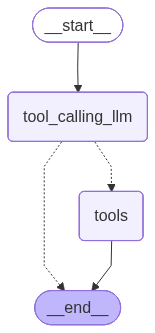

In [49]:
### Entire chatbot with langgraph
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from IPython.display import Image, display


graph_builder = StateGraph(State)

graph_builder.add_node("tool_calling_llm", tool_calling_llm)
graph_builder.add_node("tools", ToolNode(tools))

graph_builder.add_edge(START, "tool_calling_llm")
graph_builder.add_conditional_edges("tool_calling_llm", tools_condition)
graph_builder.add_edge("tools", END)

graph = graph_builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))


In [50]:
msgs = graph.invoke({"messages": "What is current status of Iran?"})

In [51]:
for msg in msgs["messages"]:
    msg.pretty_print()

================================ Human Message =================================

What is current status of Iran?
================================== Ai Message ==================================
Tool Calls:
  tavily_search (kcckjhsf5)
 Call ID: kcckjhsf5
  Args:
    query: current status of Iran
    search_depth: advanced
    time_range: day
================================= Tool Message =================================
Name: tavily_search

{"query": "current status of Iran", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.iranintl.com/en/202602275526", "title": "Reports of power shifts in Tehran put spotlight on Larijani", "content": "The divergence in reactions underscored the high stakes ahead of Thursday’s talks in Geneva, widely seen as a potentially decisive round amid reports that Washington has set informal timelines for progress.\n\nIranian officials sought to project steadiness.\n\nPresident Masoud Pezeshkian said negotiations were